# Random Forest Analysis

This Random Forest analysis was made from real data to predict turnover in an unnamed company. I created a hyperparameter grid to determine the best parameters to use in the model. The resulting predictive accuracy of the model was 80%.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import requests
import io

#!pip install lifelines --user
#from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter

# Import sklearn functions
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

#Get data from Github
url = "https://raw.githubusercontent.com/nickjmichal/projects/main/EMPLOYEE%20DATA%20-%20obfuscated.csv"
download = requests.get(url).content

dfbase = pd.read_csv(io.StringIO(download.decode('utf-8')))

dfbase.head()

,Department,Job Title,Job Area,Standard Hours,Marital Status,Hourly Rate,FULLTIME_IND,Days in Role,days_employed,Years of Service,...,Days Employed When Survey Sent,Days With Company on Submit of Survey,PC,Division,Unnamed: 18,Job Title.1,ED & DHS Average Rating,Immediate Supervisor Average Rating,Communication and Campus Average Rating,Department Morale Rating
0,58-Facility Admin,Executive Director,Executive Director,40.0,M,55.57,1,365.0,365,1.000000,...,365,365,411,North Ohio,Region A,Executive Director,0.00,5.00,4.20,4
1,58-Facility Admin,Executive Director,Executive Director,40.0,S,42.12,1,479.0,870,2.383562,...,0,30,518,North Michigan,Region B,Executive Director,4.88,5.00,5.00,5
2,58-Facility Admin,AP/Payroll Coordinator,Finance,40.0,S,14.90,1,564.0,731,2.002740,...,0,182,101,Southwest Indiana,Region C,AP/Payroll Coordinator,5.00,5.00,5.00,4
3,58-Facility Admin,AP/Payroll Coordinator,Finance,40.0,M,20.18,1,567.0,567,1.553425,...,0,183,145,South Kentucky,Region D,AP/Payroll Coordinator,3.00,4.63,3.83,4
4,58-Facility Admin,AP/Payroll Coordinator,Finance,40.0,S,17.98,1,700.0,700,1.917808,...,0,183,162,North Central Indiana,Region E,AP/Payroll Coordinator,3.88,4.88,3.67,4


In [3]:
#Select variables I want
df = dfbase[['Job Area', 
             'Hourly Rate', 
             'FULLTIME_IND', 
             'days_employed', 
             'apprenticeship_ind',
             'term_ind', 
             'Division',
             'ED & DHS Average Rating',
             'Immediate Supervisor Average Rating',
             'Communication and Campus Average Rating', 
             'Department Morale Rating'
            ]].copy()

df.head()

,Job Area,Hourly Rate,FULLTIME_IND,days_employed,apprenticeship_ind,term_ind,Division,ED & DHS Average Rating,Immediate Supervisor Average Rating,Communication and Campus Average Rating,Department Morale Rating
0,Executive Director,55.57,1,365,0,1,North Ohio,0.00,5.00,4.20,4
1,Executive Director,42.12,1,870,0,1,North Michigan,4.88,5.00,5.00,5
2,Finance,14.90,1,731,0,1,Southwest Indiana,5.00,5.00,5.00,4
3,Finance,20.18,1,567,0,1,South Kentucky,3.00,4.63,3.83,4
4,Finance,17.98,1,700,0,1,North Central Indiana,3.88,4.88,3.67,4


In [4]:
# Create dummy variables for remaining categorical variables
df = pd.get_dummies(df, columns = ['Job Area', 'Division'])

# List the names of the numeric columns in the new dataframe
df.select_dtypes(include='number').columns
#df.head()

Index(['Hourly Rate', 'FULLTIME_IND', 'days_employed', 'apprenticeship_ind',
       'term_ind', 'ED & DHS Average Rating',
       'Immediate Supervisor Average Rating',
       'Communication and Campus Average Rating', 'Department Morale Rating',
       'Job Area_Activities Associate', 'Job Area_Community Services Rep',
       'Job Area_Customer Service Specialist', 'Job Area_Dining Services',
       'Job Area_Director', 'Job Area_Environmental Services Asst',
       'Job Area_Executive Director', 'Job Area_Finance',
       'Job Area_Guest Relations', 'Job Area_Licensed Practical Nurse',
       'Job Area_Manager', 'Job Area_Other', 'Job Area_Technician',
       'Job Area_Transportation Associate', 'Division_Central Ohio',
       'Division_Central South Indiana', 'Division_Closed',
       'Division_North Central Indiana', 'Division_North Indiana',
       'Division_North Michigan', 'Division_North Ohio', 'Division_Paragon',
       'Division_South Kentucky', 'Division_South Ohio',
       

In [5]:
#Set up model paramaters
y = df['term_ind']
model_df = df[['Hourly Rate', 'FULLTIME_IND', 'days_employed', 'apprenticeship_ind', 'ED & DHS Average Rating',
       'Immediate Supervisor Average Rating',
       'Communication and Campus Average Rating', 'Department Morale Rating',
       'Job Area_Activities Associate', 'Job Area_Community Services Rep',
       'Job Area_Customer Service Specialist', 'Job Area_Dining Services',
       'Job Area_Director', 'Job Area_Environmental Services Asst',
       'Job Area_Executive Director', 'Job Area_Finance',
       'Job Area_Guest Relations',
       'Job Area_Manager', 'Job Area_Other', 'Job Area_Technician',
       'Job Area_Transportation Associate', 'Division_Central Ohio',
       'Division_Central South Indiana', 'Division_Closed',
       'Division_North Central Indiana', 'Division_North Indiana',
       'Division_North Michigan', 'Division_North Ohio', 'Division_Paragon',
       'Division_South Kentucky', 'Division_South Ohio',
       'Division_Southeast Indiana', 'Division_Southwest Indiana',
       'Division_TMS Home Office']]

# Split the data into balanced training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=0.33,
                                                    random_state=42, stratify=y)


In [6]:
# Fit the scaler to the training data
scaler = StandardScaler().fit(X_train)

# Use the scaler to transform the training and testing data
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [7]:
#RANDOM FOREST

# Create a model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100,
                                 random_state=42,
                                 max_features='sqrt',
                                 n_jobs=-1, verbose=1)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Create a hyperparameter grid
param_grid = {'n_estimators': np.linspace(10, 200).astype(int),
             'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
             'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
             'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
             'min_samples_split': [2, 5, 10],
             'bootstrap': [True, False]}

# Create the estimator for use in random search
estimator = RandomForestClassifier(random_state=42)

# Create the random search model
rs_model = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,
                             scoring='roc_auc', cv=3,
                             n_iter=10, verbose=1, random_state=42)

# Fit the model to the training data
rs_model.fit(X_train, y_train)

# Find the best parameters
rs_model.best_params_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.5s finished


{'n_estimators': 196,
 'min_samples_split': 10,
 'max_leaf_nodes': 49,
 'max_features': 0.7,
 'max_depth': 17,
 'bootstrap': True}

Average number of nodes: 97
Average maximum depth: 11
Accuracy of classifier on test set: 0.80066

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75       961
           1       0.85      0.82      0.83      1467

    accuracy                           0.80      2428
   macro avg       0.79      0.80      0.79      2428
weighted avg       0.80      0.80      0.80      2428

Confusion Matrix:
 [[1640  311]
 [ 426 2552]]


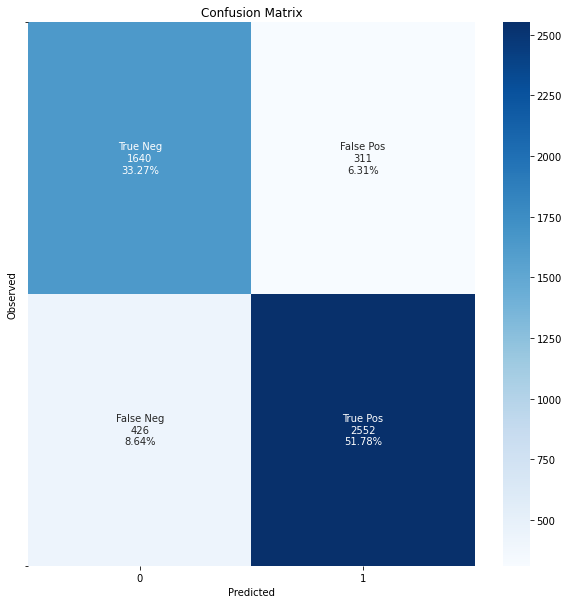

In [8]:
# Use the best model to evaluate our model fit
best_model = rs_model.best_estimator_

ytrain_pred = best_model.predict(X_train)
ytrain_prob = best_model.predict_proba(X_train)[:, 1]

ytest_pred = best_model.predict(X_test)
ytest_prob = best_model.predict_proba(X_test)[:, 1]

# Find summary statistics of decision trees in random forest
n_nodes = []
max_depths = []

for each_tree in best_model.estimators_:
    n_nodes.append(each_tree.tree_.node_count)
    max_depths.append(each_tree.tree_.max_depth)

print('Average number of nodes:', int(np.mean(n_nodes)))
print('Average maximum depth:', int(np.mean(max_depths)))

# Calculate accuracy on test set
best_model_accuracy = best_model.score(X_test, y_test)
print('Accuracy of classifier on test set: {:.5f}'.format(best_model_accuracy))

# Print classification report
print('\nClassification report:\n', classification_report(y_test, ytest_pred))

# Create confusion matrix for training data
cf_matrix = confusion_matrix(y_train, ytrain_pred)
print('Confusion Matrix:\n', cf_matrix)

# Visualize and label confusion matrix with values and percentages
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
pos, textvals = plt.yticks()
plt.yticks([0, 2], fontsize="10", va="center")
plt.title('Confusion Matrix')
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.show()

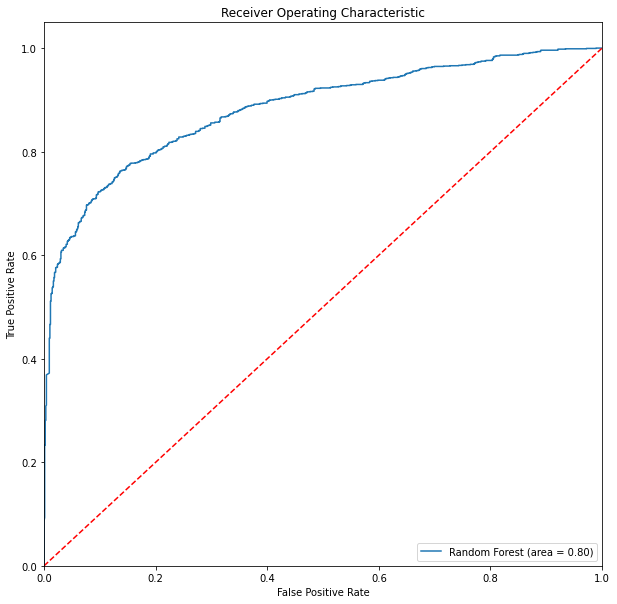

In [9]:
# Calculate ROC AUC score
rf_roc_auc = roc_auc_score(y_test, ytest_pred)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, ytest_prob)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



In [10]:
# Find the most important features in the decision tree
feat = pd.DataFrame({'feature': list(X_train.columns),
                    'importance': rf_model.feature_importances_}).sort_values('importance',
                                                                           ascending=False).reset_index(drop=True)
feat[feat['importance'] > 0]

,feature,importance
0,Hourly Rate,0.226596
1,days_employed,0.186565
2,apprenticeship_ind,0.152485
3,ED & DHS Average Rating,0.065767
4,Communication and Campus Average Rating,0.064604
5,Immediate Supervisor Average Rating,0.064505
6,Department Morale Rating,0.034386
7,FULLTIME_IND,0.020298
8,Job Area_Dining Services,0.013270
9,Division_Southwest Indiana,0.011392
